# Actividad 4.2 - Deteccion de Señales de Transito usando Keras
##### Carem Angelica Bernabe Acosta - A01797101
##### David Emmanuel Villanueva Martinez - A01638389
##### Yander Alec Ortega Rosales - A01284479


In [1]:
# Import necessary libraries
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
import pandas as pd
import os
import cv2
from PIL import Image

import tensorflow as tf
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
dataset_path = "/content/drive/MyDrive/MNA/Navegacion Autonoma/Navigation Dataset/Navigation Dataset"
dataset_zip = "/content/drive/MyDrive/MNA/Navegacion Autonoma/Navigation Dataset/Navigation Dataset.zip"

In [3]:
os.getcwd()

'c:\\Users\\eclip\\OneDrive\\Documentos\\MNA\\6to Trimestre\\Navegacion Autonoma'

##Classes

Our dataset includes the following classes:

0 -->
1 -->
2 -->
3 -->
4 -->
5 -->
6 -->
7 -->
8 -->
9 -->
10 -->
11 -->
12 -->
13 -->
14 -->



In [4]:
metadata_path = os.path.join(os.getcwd(), "Navigation Dataset")

cols = ["name", "steering angle"]
metadata_df = pd.read_csv(os.path.join(metadata_path, "metadata.csv"), usecols=cols)
metadata_df.head()

,name,steering angle
0,2025-06-13 21-02-12.png,0.0
1,2025-06-13 21-02-13.png,0.0
2,2025-06-13 21-02-14.png,0.0
3,2025-06-13 21-02-16.png,0.0
4,2025-06-13 21-02-17.png,0.0


In [5]:
metadata_df.dropna(inplace=True)

In [6]:
metadata_df = metadata_df[:5100]

In [7]:
metadata_df


,name,steering angle
0,2025-06-13 21-02-12.png,0.0
1,2025-06-13 21-02-13.png,0.0
2,2025-06-13 21-02-14.png,0.0
3,2025-06-13 21-02-16.png,0.0
4,2025-06-13 21-02-17.png,0.0
...,...,...
5095,2025-06-14 14-30-45.png,0.0
5096,2025-06-14 14-30-47.png,0.0
5097,2025-06-14 14-30-48.png,0.0
5098,2025-06-14 14-30-49.png,0.0


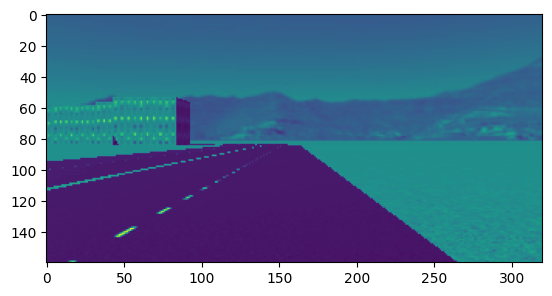

In [8]:
img = Image.open(os.path.join(metadata_path, metadata_df.iloc[5000, 0])).convert("L")
plt.imshow(img)

In [9]:
SHAPE = img.size
SHAPE

(320, 160)

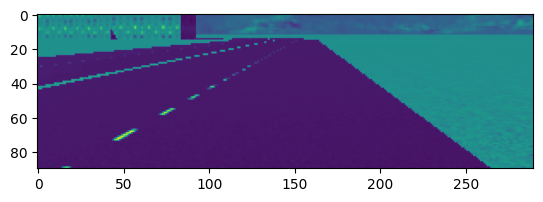

In [10]:
box = (0, 70, 290, 160)

img_crop = img.crop(box)
plt.imshow(img_crop)

## Loading Dataset

In [11]:
def load_and_preprocess(df, base_path):
    data = []
    labels = []
    box = (0, 70, 290, 160)   # Crop bounding box

    for idx, row in df.iterrows():
        img_path = os.path.join(base_path, row['name'])
        img = Image.open(img_path).convert("L")
        img = img.crop(box)
        arr = np.array(img, dtype="float32") / 255.0
        data.append(arr)
        labels.append(row['steering angle'])
        print(f"Loaded image {idx}")

    return np.array(data), np.array(labels)

In [12]:
X, y = load_and_preprocess(metadata_df, metadata_path)

Loaded image 0
Loaded image 1
Loaded image 2
Loaded image 3
Loaded image 4
Loaded image 5
Loaded image 6
Loaded image 7
Loaded image 8
Loaded image 9
Loaded image 10
Loaded image 11
Loaded image 12
Loaded image 13
Loaded image 14
Loaded image 15
Loaded image 16
Loaded image 17
Loaded image 18
Loaded image 19
Loaded image 20
Loaded image 21
Loaded image 22
Loaded image 23
Loaded image 24
Loaded image 25
Loaded image 26
Loaded image 27
Loaded image 28
Loaded image 29
Loaded image 30
Loaded image 31
Loaded image 32
Loaded image 33
Loaded image 34
Loaded image 35
Loaded image 36
Loaded image 37
Loaded image 38
Loaded image 39
Loaded image 40
Loaded image 41
Loaded image 42
Loaded image 43
Loaded image 44
Loaded image 45
Loaded image 46
Loaded image 47
Loaded image 48
Loaded image 49
Loaded image 50
Loaded image 51
Loaded image 52
Loaded image 53
Loaded image 54
Loaded image 55
Loaded image 56
Loaded image 57
Loaded image 58
Loaded image 59
Loaded image 60
Loaded image 61
Loaded image 62
Lo

In [13]:
X.shape

(5100, 90, 290)

In [14]:
y.shape

(5100,)

## Train Test Split

In [15]:

x_train, x_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

# Del 85% restante:  ~15% ≈ 0.176 para validación
x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

print("Shapes after splitting:")
print("  x_train:", x_train.shape, " y_train:", y_train.shape)
print("  x_val:  ", x_val.shape,   " y_val:  ", y_val.shape)
print("  x_test: ", x_test.shape,  " y_test: ", y_test.shape)


Shapes after splitting:
  x_train: (4080, 90, 290)  y_train: (4080,)
  x_val:   (510, 90, 290)  y_val:   (510,)
  x_test:  (510, 90, 290)  y_test:  (510,)


## CNN model definition

In [16]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
# from keras.optimizers import Adam

# model = Sequential()

# model.add(Conv2D(filters=24, kernel_size=(5, 5), activation='elu', input_shape=(90, 290, 1)))
# model.add(Conv2D(filters=36, kernel_size=(5, 5), activation='elu'))
# model.add(Conv2D(filters=48, kernel_size=(5, 5), activation='elu'))
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu'))

# model.add(Flatten())
# model.add(Dense(100, activation='elu'))
# model.add(Dense(50, activation='elu'))
# model.add(Dense(10, activation='elu'))

# model.add(Dense(1))

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(filters=24, kernel_size=(3, 3), activation='elu', input_shape=(90, 290, 1)))
model.add(Conv2D(filters=36, kernel_size=(3, 3), activation='elu'))
model.add(Conv2D(filters=36, kernel_size=(3, 3), activation='elu'))

model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(10, activation='elu'))

model.add(Dense(1))

C:\Users\eclip\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer=Adam(), loss='mse')
# plot_model(model, show_shapes=True)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 88, 288, 24)    │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 86, 286, 36)    │         7,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 84, 284, 36)    │        11,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 858816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    85,881,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,902,473 (327.69 MB)

 Trainable params: 85,902,473 (327.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=100, 
    verbose=1,
    shuffle = 1,
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 4121.2051 - val_loss: 0.3872
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - loss: 1.8881 - val_loss: 13.1828
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 13.1721 - val_loss: 13.0787
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - loss: 13.0633 - val_loss: 12.9510
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - loss: 12.9411 - val_loss: 12.8069
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - loss: 12.7908 - val_loss: 12.6486
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 12.6314 - val_loss: 12.4779
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 12.4493 - val_loss: 12.2961
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 12.2735 - val_loss: 12.1045
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 12.0742 - val_loss: 11.9042
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 11.8640 - val_loss: 11.6961
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/ste

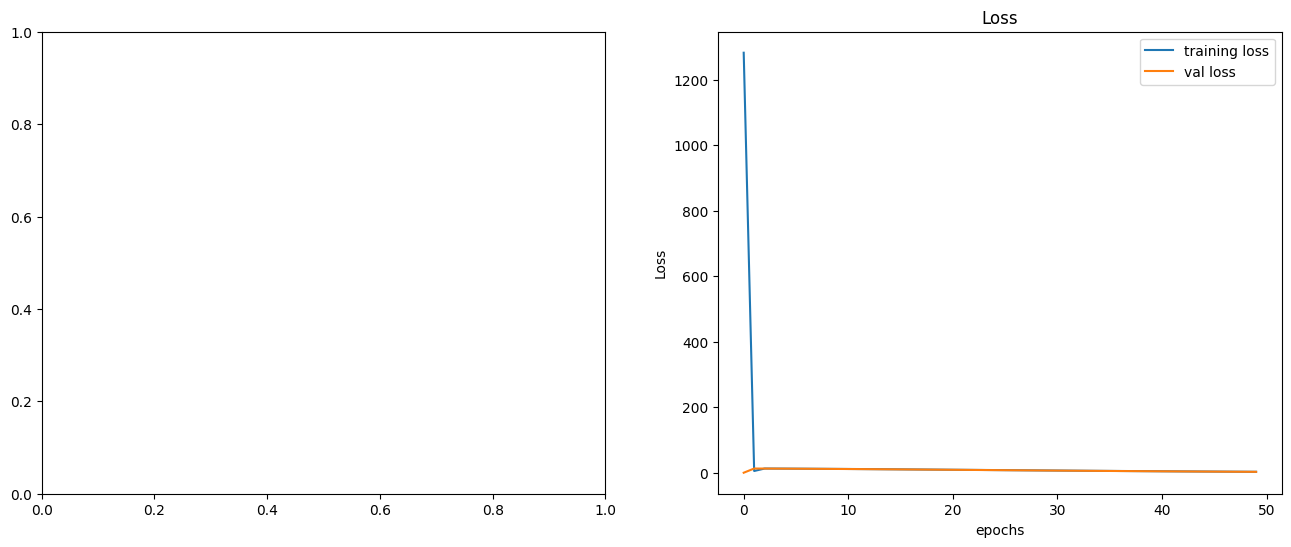

In [21]:
fig, axs = plt.subplots(1,2, figsize=(16,6))

# # Grafica de exactitud
# axs[0].plot(history.history['accuracy'], label="Training accuracy")
# axs[0].plot(history.history['val_accuracy'], label="val accuracy")
# axs[0].set_title("Accuracy")
# axs[0].set_xlabel("epochs")
# axs[0].set_ylabel("accuracy")
# axs[0].legend()

# Grafica del error
axs[1].plot(history.history['loss'], label="training loss")
axs[1].plot(history.history['val_loss'], label="val loss")
axs[1].set_title("Loss")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()
plt.show()

In [22]:
loss = model.evaluate(x=x_test, y=y_test, batch_size=100)
print(f"Test Loss: {loss}")
# print(f"Test Accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - loss: 3.1342
Test Loss: 3.13033127784729


In [23]:
import joblib

joblib.dump(model, "third_model.joblib")

['third_model.joblib']